### <center> The purpose of this notebook is to create the coastal and tropical masks for each S2S and observational product in a way that a correct kelvin-wave pathway can be extracted from global data.

There are three global global grids to consider:
* ERA5/ASCAT 0.25°x0.25° grid
* GLORYS12V1 0.08°x0.08° grid
* S2S 1°x1° grid

For each of these global grids the notebook has a section dedicated to the mask building.

In [2]:

from glob import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import scipy.signal as signal
from scipy.interpolate import interp1d
import os

---

#### <center> ECMWF S2S REFORECASTS


In [52]:
# Load a single file
reforecast = xr.open_dataset('data/S2S/REFORECASTS/control/2020-01-06/2000-01-06_O2D.nc')
reforecast = reforecast.sortby('lat').sortby('lon').sel({'lon':slice(110,290),'lat':slice(-40,40)})
reforecast = reforecast.assign_coords({'i':('lat',range(len(reforecast.lat))),'j':('lon',range(len(reforecast.lon)))})
lon,lat = np.meshgrid(reforecast.lon,reforecast.lat) # Get grid

reforecast

<xarray.Dataset>
Dimensions:       (time: 46, lon: 181, lat: 81, depth: 1, depth_2: 1, bnds: 2)
Coordinates:
  * time          (time) datetime64[ns] 2000-01-07 2000-01-08 ... 2000-02-21
  * lon           (lon) float32 110.0 111.0 112.0 113.0 ... 288.0 289.0 290.0
  * lat           (lat) float32 -40.0 -39.0 -38.0 -37.0 ... 37.0 38.0 39.0 40.0
  * depth         (depth) float64 0.0
  * depth_2       (depth_2) float64 150.0
    i             (lat) int64 0 1 2 3 4 5 6 7 8 9 ... 72 73 74 75 76 77 78 79 80
    j             (lon) int64 0 1 2 3 4 5 6 7 ... 174 175 176 177 178 179 180
Dimensions without coordinates: bnds
Data variables:
    depth_2_bnds  (depth_2, bnds) float64 ...
    dslm          (time, depth, lat, lon) float32 ...
    param18.4.10  (time, depth_2, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.6
    history:      Thu Jul 06 17:57:22 2023: cdo -f nc copy 2000-01-06.grb REF...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.9.3 (http://mpimet.mpg.de/...

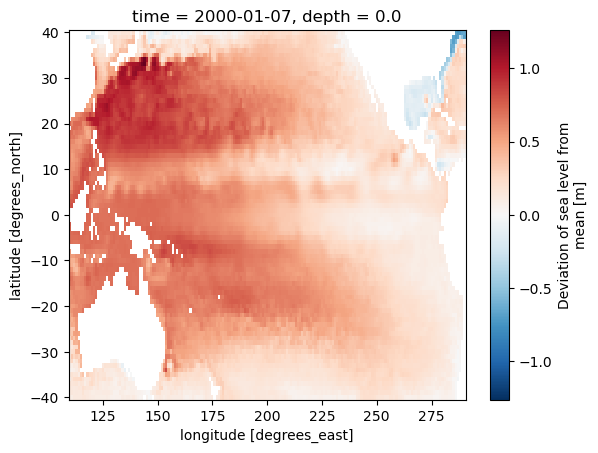

In [53]:
# Snapshot to sea level at initialization time
reforecast['dslm'].isel(time=0).plot()

In [61]:
# Build tropical mask
tropicalmask = reforecast.dslm[0,0,:,:].where(reforecast.lat>=-2).where(reforecast.lat<=2)
tropicalmask = xr.where(~np.isnan(tropicalmask),1,0).to_dataset(name='tropicalmask').drop('j').drop('i')

In [104]:
# Build coastal mask

watermask = reforecast.dslm[0,0,:,:].fillna(-9999).sel(lon=slice(220,290)) # Get water pixels
watermask = watermask.assign_coords({'i':('lat',range(len(watermask.lat))),'j':('lon',range(len(watermask.lon)))}) # Assign indexes to lat,lon coords
watermask = xr.where(watermask==-9999,0,1) # Get water pixels as 0/1 values
watermask = watermask.differentiate('lon')!=0 # Get coastline
watermask = watermask.where(watermask).ffill('lon') # Mask out all pixels after western america coastline
x = xr.concat([watermask[i,:].dropna('lon').isel(lon=0).j for i in range(len(watermask.lat))],'lat') # Coastline latitude
watermask = xr.where(watermask==9999,1,0) # Set everything to 0
watermask[:,x[:]] = 1 # Set coastline to true

# Set some pixels to True by "hand" for coastline continuity
watermask[23,[65,67]]=1
watermask[33,58]=1
watermask[37,58]=1
watermask[47,[58,59,60]]=1
watermask[48,56]=1
watermask[53,[48,49,50]]=1
watermask[55,[42,43,44,45]]=1
watermask[55,[42,43,44,45]]=1
watermask[56,[39,40]]=1
watermask[58,[35,36,37]]=1
watermask[62,[29,30,31,32]]=1
watermask[64,27]=1
watermask[74,19]=1
watermask[37,59]=1
watermask[33,59]=1
watermask[23,[66,68]]=1
watermask[47,[57,61]]=1
watermask[48,[57]]=1
watermask[53,[51]]=1
watermask[55,[46]]=1
watermask[56,[41]]=1
watermask[62,[33]]=1
watermask[64,[28]]=1
watermask[74,[20]]=1

watermask = watermask.where(abs(reforecast.lat)>2).fillna(0) # Set tropical band to false
# Grab southern and northern hemisphere coastal masks
coastmask_south = watermask.sel(lat=slice(-90,-2)).reindex({'lat':tropicalmask.lat,'lon':tropicalmask.lon}).fillna(0).to_dataset(name='coastmask_south').drop('j').drop('i')
coastmask_north = watermask.sel(lat=slice(2,90)).reindex({'lat':tropicalmask.lat,'lon':tropicalmask.lon}).fillna(0).to_dataset(name='coastmask_north').drop('j').drop('i')

In [106]:
# Merge everything and drop useless coordinates
masks = xr.merge([tropicalmask,coastmask_south,coastmask_north]).drop(['depth','time'])
masks

<xarray.Dataset>
Dimensions:          (lon: 181, lat: 81)
Coordinates:
  * lon              (lon) float32 110.0 111.0 112.0 113.0 ... 288.0 289.0 290.0
  * lat              (lat) float32 -40.0 -39.0 -38.0 -37.0 ... 38.0 39.0 40.0
Data variables:
    tropicalmask     (lat, lon) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    coastmask_south  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    coastmask_north  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

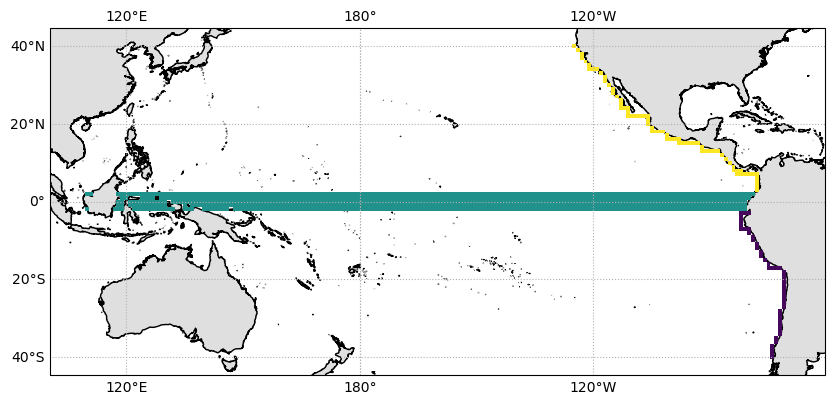

In [134]:
# Quick look to the new masks
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
ax.coastlines('10m')
ax.add_feature(cf.LAND, color='silver', alpha=0.5)
ax.gridlines(draw_labels=True, linestyle=":")
(masks.tropicalmask.where(masks.tropicalmask==1)).plot(add_colorbar=False, vmin=1,vmax=1, ax=ax, transform=ccrs.PlateCarree())
(masks.coastmask_north.where(masks.coastmask_north==1)+1).plot(add_colorbar=False, vmin=1, vmax=2, ax=ax, transform=ccrs.PlateCarree())
(masks.coastmask_south.where(masks.coastmask_south==1)+2).plot(add_colorbar=False, vmin=1, vmax=100, ax=ax, transform=ccrs.PlateCarree())

As we can see in the previous figure, three interesting masks has been made:
* Green: Tropical mask from 2°S to 2°N for all the pacific basin (west of 180°E there is some land!! so be carefull) 
* Yellow: Western North America coastal mask, ranging from Ecuador to the US, skipping the Gulf of California.
* Dark Purple: Western South America coastal mask ranging from Ecuador to Chile

Now some attributes will be added and the new mask dataset stored on disk

In [90]:
# Add some attributes
masks.attrs = {'name':'S2S KW Masks',
               'institution':'Centro de estudios avanzados en zonas aridas (CEAZA)',
               'description':'Tropical and coastal masks for the eastern pacific based on the S2S ocean forecast dataset',
               'author':'Lucas Glasner',
               'contact':'lucas.glasner@ceaza.cl'}
masks.tropicalmask.attrs    = {'name':'tropicalmask','long_name':'1°x1° Tropical Mask'}
masks.coastmask_south.attrs = {'name':'coastmask_south','long_name':'SE Pacific Coastal mask for SouthAmerica'}
masks.coastmask_north.attrs = {'name':'coastmask_north','long_name':'SE Pacific Coastal mask for NorthAmerica'}

In [91]:
masks.to_netcdf('data/S2S_masks.nc')

---

### GLORYS

In [2]:
import geopandas as gpd
import regionmask
coastline = gpd.read_file('data/ne_10m_land.shp')

In [3]:
glorys = xr.open_dataset('data/GLORYS12V1/HOVMOLLERS/domain.nc').zos
glorys.coords['i'] = ('latitude',np.arange(len(glorys.latitude)))
glorys.coords['j'] = ('longitude', np.arange(len(glorys.longitude)))

In [4]:
tropicalmask = glorys.where(glorys.latitude>-2).where(glorys.latitude<2)>-9999
mask = regionmask.mask_geopandas(coastline, glorys.longitude, glorys.latitude)==0
mask = mask.astype(float).differentiate('j')
mask = mask>0
mask = ((mask.where(mask).ffill('longitude'))==1).astype(float).differentiate('j')
mask = mask.where(mask).bfill('longitude', limit=8)==0.5

coastmask_north = xr.where(mask.latitude>2, mask, 0)
coastmask_south = xr.where(mask.latitude<-2, mask,0)

In [5]:
masks = xr.merge([tropicalmask.to_dataset(name='tropicalmask'), coastmask_north.to_dataset(name='coastmask_north'), coastmask_south.to_dataset(name='coastmask_south')]).astype(float)

In [321]:
masks.drop('time').to_netcdf('data/GLORYS_MASKS.nc')

In [316]:
# glorys_tropicalmask   = masks.tropicalmask.reindex({'lon':360+glorys.longitude.values, 'lat':glorys.latitude.values}, method='nearest').rename({'lon':'longitude','lat':'latitude'}).to_dataset(name='tropicalmask')
# glorys_coastnorthmask = masks.coastmask_north.reindex({'lon':360+glorys.longitude.values, 'lat':glorys.latitude.values}, method='nearest').rename({'lon':'longitude','lat':'latitude'}).to_dataset(name='coastmask_north')
# glorys_coastsouthmask = masks.coastmask_south.reindex({'lon':360+glorys.longitude.values, 'lat':glorys.latitude.values}, method='nearest').rename({'lon':'longitude','lat':'latitude'}).to_dataset(name='coastmask_south')

# glorys_tropicalmask.coords['longitude'] = (glorys_tropicalmask.longitude + 180) % 360 - 180
# glorys_coastnorthmask.coords['longitude'] = (glorys_coastnorthmask.longitude + 180) % 360 - 180
# glorys_coastsouthmask.coords['longitude'] = (glorys_coastsouthmask.longitude + 180) % 360 - 180
# glorys_masks = xr.merge([glorys_tropicalmask, glorys_coastnorthmask, glorys_coastsouthmask])
# # glorys_masks.to_netcdf('data/GLORYS_MASKS.nc')

---

### ERA5 

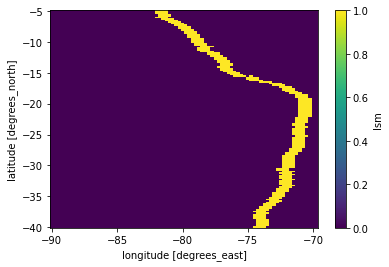

In [56]:
# load and build coastal mask
from scipy.ndimage import binary_fill_holes
mask = xr.open_dataset('~/storage/ERA5/COQUIMBO_VIENTO/LANDSEAMASK.nc').lsm
mask = xr.apply_ufunc(binary_fill_holes, mask).sortby('latitude').sortby('longitude')
mask = 1-mask.isel(longitude=slice(0,-3)).sel(latitude=slice(-40,-5))
x    = mask.where(mask==0).bfill('longitude', limit=4)==0
mask = (x+mask)==2
mask.plot()

In [58]:
mask.to_dataset(name='coastmask_south').to_netcdf('data/ERA5_MASKS.nc')

---

#### ECMWF ATMOSPHERE REFORECASTS

In [50]:
data = xr.open_dataset('data/S2S/reforecasts/2020-01-06/2000-01-06_WINDS.nc')
data.coords['lon'] = (data.coords['lon']+180)%360-180
data = data.sortby('lon')
data = data.squeeze().sel(lat=slice(-5,-40)).sel(lon=slice(-90,-69))
# mask2 = (x+mask).interp(longitude=data.lon, latitude=data.lat.values, method='nearest')